In [ ]:
# Importing required libraries
import re
import pandas as pd
import numpy as np
import math
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import Word
from collections import Counter
import wordcloud
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# reading the csv file
twitter = pd.read_csv("twitter_training.csv")

In [ ]:
# first 5 rows
twitter.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
# last 5 rows
twitter.tail()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
23998,4513,Google,Neutral,"A truly incredible game. Gaming is the ""show o..."
23999,4514,Google,Neutral,“Android Becomes Basically Unusable If You Tur...
24000,4514,Google,Neutral,"""Android basically becomes useless if you turn..."
24001,4514,Google,Neutral,"""Android Becomes the Unusable If You Turn Off ..."
24002,4514,Google,Neutral,“Android Becomes Basically Illegal If You Pay ...


In [ ]:
# column names
twitter.columns

Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')

In [ ]:
# changing the name of the columns
twitter.rename(columns={"Positive":"Sentiment", "im getting on borderlands and i will murder you all ,":"Tweet Content",
                        "2401":"Tweet Id","Borderlands":"Entity"},inplace=True)

In [ ]:
twitter.columns

Index(['Tweet Id', 'Entity', 'Sentiment', 'Tweet Content'], dtype='object')

In [ ]:
# dimensions of the dataset
twitter.shape

(24003, 4)

In [ ]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24003 entries, 0 to 24002
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet Id       24003 non-null  int64 
 1   Entity         24003 non-null  object
 2   Sentiment      24003 non-null  object
 3   Tweet Content  23783 non-null  object
dtypes: int64(1), object(3)
memory usage: 750.2+ KB


In [ ]:
twitter.describe()

,Tweet Id
count,24003.000000
mean,6472.326251
std,4402.339466
min,1.000000
25%,2629.000000
50%,4461.000000
75%,9777.000000
max,13200.000000


In [ ]:
# checking for null values
twitter.isnull().sum()

Tweet Id           0
Entity             0
Sentiment          0
Tweet Content    220
dtype: int64

In [ ]:
# filtering all the null rows
isnull = twitter["Tweet Content"].isnull()
twitter[isnull]

,Tweet Id,Entity,Sentiment,Tweet Content
60,2411,Borderlands,Neutral,NaN
552,2496,Borderlands,Neutral,NaN
588,2503,Borderlands,Neutral,NaN
744,2532,Borderlands,Positive,NaN
1104,2595,Borderlands,Positive,NaN
...,...,...,...,...
23541,4435,Google,Neutral,NaN
23542,4435,Google,Neutral,NaN
23598,4445,Google,Irrelevant,NaN
23706,4463,Google,Neutral,NaN


In [ ]:
# keeping only the not null values
notnull = twitter["Tweet Content"].notnull()
twitter=twitter[notnull]


In [ ]:
# checking again for null values
twitter.isnull().sum()

Tweet Id         0
Entity           0
Sentiment        0
Tweet Content    0
dtype: int64

In [ ]:
twitter["Sentiment"].value_counts()

Sentiment
Positive      7229
Negative      6117
Neutral       6097
Irrelevant    4340
Name: count, dtype: int64

In [ ]:
# removing irrelevant value for the sentiment column
sent = twitter["Sentiment"]!= "Irrelevant"
twitter= twitter[sent]

In [ ]:
twitter["Sentiment"].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

<Axes: ylabel='count'>

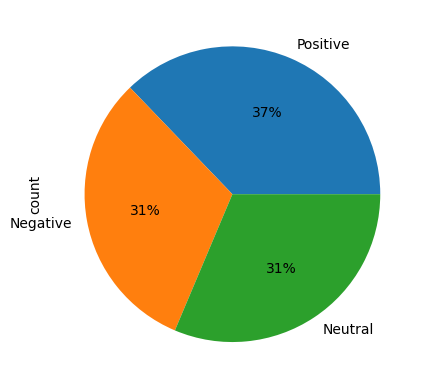

In [ ]:
# plotting pie chart
twitter["Sentiment"].value_counts().plot.pie(autopct="%.f%%")

In [ ]:
# checking the average length of all the tweets
twitter["Tweet Content"].apply(len).mean()

102.73692331430335

In [ ]:
# checking the average len of tweets for positive negative and neutral sentiment
pos = twitter["Sentiment"]== "Positive"
print("The average length of positive tweets =",twitter.loc[pos,"Tweet Content"].apply(len).mean())

neg = twitter["Sentiment"]== "Negative"
print("The average length of negative tweets =",twitter.loc[neg,"Tweet Content"].apply(len).mean())

neutral = twitter["Sentiment"]== "Neutral"
print("The average length of neutral tweets =",twitter.loc[neutral,"Tweet Content"].apply(len).mean())

The average length of positive tweets = 89.64919075944114
The average length of negative tweets = 101.79777668791891
The average length of neutral tweets = 119.19681810726587


In [ ]:
# dropping more columns
twitter.drop(columns={"Tweet Id","Entity"},inplace=True)

In [ ]:
twitter.columns

Index(['Sentiment', 'Tweet Content'], dtype='object')

In [ ]:
# eg of stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# printing the stopwords in english
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# STEMMING --> Stemming is the process of reducing a word to it's rood word
# example : actor ,actress,acting =act
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("carries"))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


carry


In [ ]:
# Text Processing
# Removing puncutation ,special characters ,symbols like {},[],\ ,white spaces,underscores,urls,html tags and stopwords

def cleaned_data(text):
    # removing characters that are not aplhabets (i.e keeping only the uppercase and lowercase alphabets)
    text = re.sub('[^a-zA-Z]',' ',text)
    # Remove extra spaces using regex (spaces added after replacing the unwanted characters with spaces.)
    text = re.sub(' +', ' ', text)
    # converting the text into lowercase
    text = text.lower()
    # splitting the text into words
    text = text.split()
    # checking for stopwords then converting the words to it's root form
    text = [lemmatizer.lemmatize(word) for word in text if not word in stopwords.words('english')]
    # then concatening the splitted words into a list
    text = ' '.join(text)
    return text

In [ ]:
twitter["Cleaned Text"] = twitter["Tweet Content"].apply(cleaned_data)

In [ ]:
twitter

,Sentiment,Tweet Content,Cleaned Text
0,Positive,I am coming to the borders and I will kill you...,coming border kill
1,Positive,im getting on borderlands and i will kill you ...,im getting borderland kill
2,Positive,im coming on borderlands and i will murder you...,im coming borderland murder
3,Positive,im getting on borderlands 2 and i will murder ...,im getting borderland murder
4,Positive,im getting into borderlands and i can murder y...,im getting borderland murder
...,...,...,...
23998,Neutral,"A truly incredible game. Gaming is the ""show o...",truly incredible game gaming show tech server ...
23999,Neutral,“Android Becomes Basically Unusable If You Tur...,android becomes basically unusable turn google...
24000,Neutral,"""Android basically becomes useless if you turn...",android basically becomes useless turn google ...
24001,Neutral,"""Android Becomes the Unusable If You Turn Off ...",android becomes unusable turn google tracking ...


In [ ]:
# for positive comments
pos = twitter["Sentiment"]=="Positive"
positive = twitter.loc[pos,"Cleaned Text"]
print("Positive text\n",positive.head(3))

neg = twitter["Sentiment"]=="Negative"
negative = twitter.loc[neg,"Cleaned Text"]
print("\nNegative text\n",negative.head(3))

neutral = twitter["Sentiment"]=="Neutral"
neutral = twitter.loc[neutral,"Cleaned Text"]
print("\nNeutral text\n",neutral.head(3))

Positive text
 0             coming border kill
1     im getting borderland kill
2    im coming borderland murder
Name: Cleaned Text, dtype: object

Negative text
 23    biggest dissappoinment life came year ago fuck...
24            biggest disappointment life came year ago
25            biggest disappointment life came year ago
Name: Cleaned Text, dtype: object

Neutral text
 11    rock hard la varlope rare powerful handsome ja...
12    rock hard la varlope rare powerful handsome ja...
13    rock hard la varlope rare powerful handsome ja...
Name: Cleaned Text, dtype: object


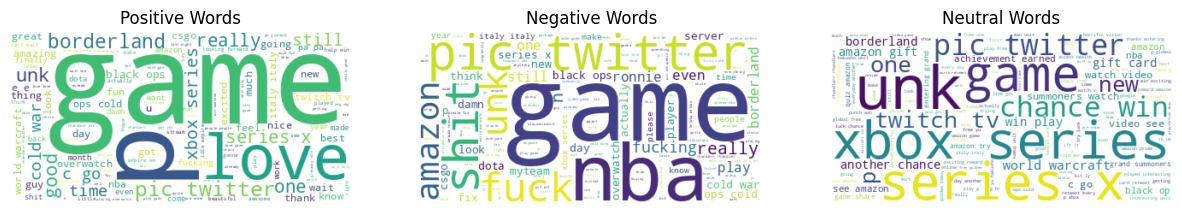

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Sample data for three classes
pos_text = " ".join(i for i in positive)
neg_text = " ".join(i for i in negative)
neutral_text = " ".join(i for i in neutral)

# Set up stopwords
stopwords = set(STOPWORDS)

# Create WordCloud objects for each class
wordcloud1 = WordCloud(stopwords=stopwords, background_color="white").generate(pos_text)
wordcloud2 = WordCloud(stopwords=stopwords, background_color="white").generate(neg_text)
wordcloud3 = WordCloud(stopwords=stopwords, background_color="white").generate(neutral_text)

# Create a plot with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# Plot each word cloud in its respective subplot
axes[0].imshow(wordcloud1, interpolation='bilinear')
axes[0].set_title("Positive Words")
axes[0].axis("off")

axes[1].imshow(wordcloud2, interpolation='bilinear')
axes[1].set_title("Negative Words")
axes[1].axis("off")

axes[2].imshow(wordcloud3, interpolation='bilinear')
axes[2].set_title("Neutral Words")
axes[2].axis("off")

# Show the plot
plt.show()

In [ ]:
# Encoded the target column
lb=LabelEncoder()
twitter['Sentiment'] = lb.fit_transform(twitter['Sentiment'])
# zero is negative 1 is neutral and 2 is positive

In [ ]:
twitter

,Sentiment,Tweet Content,Cleaned Text
0,2,I am coming to the borders and I will kill you...,coming border kill
1,2,im getting on borderlands and i will kill you ...,im getting borderland kill
2,2,im coming on borderlands and i will murder you...,im coming borderland murder
3,2,im getting on borderlands 2 and i will murder ...,im getting borderland murder
4,2,im getting into borderlands and i can murder y...,im getting borderland murder
...,...,...,...
23998,1,"A truly incredible game. Gaming is the ""show o...",truly incredible game gaming show tech server ...
23999,1,“Android Becomes Basically Unusable If You Tur...,android becomes basically unusable turn google...
24000,1,"""Android basically becomes useless if you turn...",android basically becomes useless turn google ...
24001,1,"""Android Becomes the Unusable If You Turn Off ...",android becomes unusable turn google tracking ...


In [ ]:
twitter.drop(columns="Tweet Content")

,Sentiment,Cleaned Text
0,2,coming border kill
1,2,im getting borderland kill
2,2,im coming borderland murder
3,2,im getting borderland murder
4,2,im getting borderland murder
...,...,...
23998,1,truly incredible game gaming show tech server ...
23999,1,android becomes basically unusable turn google...
24000,1,android basically becomes useless turn google ...
24001,1,android becomes unusable turn google tracking ...


In [ ]:
# Tokenizing and converting the reviews into numerical vectors.
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(twitter["Cleaned Text"].values)
X = tokenizer.texts_to_sequences(twitter["Cleaned Text"].values)
X = pad_sequences(X)

In [ ]:
X

array([[  0,   0,   0, ...,   0, 326, 338],
       [  0,   0,   0, ...,  94,   6, 338],
       [  0,   0,   0, ..., 133, 326,   6],
       ...,
       [  0,   0,   0, ..., 365,   3,  58],
       [  0,   0,   0, ..., 365,   3,  58],
       [  0,   0,   0, ..., 324,  12,  45]], dtype=int32)

# **Building a RNN Model**

In [ ]:
y = twitter["Sentiment"]
y

0        2
1        2
2        2
3        2
4        2
        ..
23998    1
23999    1
24000    1
24001    1
24002    1
Name: Sentiment, Length: 19443, dtype: int64

In [ ]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 143, 120)          60000     
                                                                 
 spatial_dropout1d (Spatial  (None, 143, 120)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 3)                 531       
                                                                 
Total params: 269619 (1.03 MB)
Trainable params: 269619 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [ ]:
batch_size=32
model.fit(X_train, y_train, epochs = 10, batch_size=batch_size)


Epoch 1/10
487/487 [==============================] - 302s 613ms/step - loss: 0.8615 - accuracy: 0.6084
Epoch 2/10
487/487 [==============================] - 301s 619ms/step - loss: 0.7193 - accuracy: 0.6854
Epoch 3/10
487/487 [==============================] - 295s 606ms/step - loss: 0.6719 - accuracy: 0.7057
Epoch 4/10
487/487 [==============================] - 296s 608ms/step - loss: 0.6339 - accuracy: 0.7251
Epoch 5/10
487/487 [==============================] - 300s 616ms/step - loss: 0.6007 - accuracy: 0.7385
Epoch 6/10
487/487 [==============================] - 296s 609ms/step - loss: 0.5742 - accuracy: 0.7531
Epoch 7/10
487/487 [==============================] - 300s 615ms/step - loss: 0.5421 - accuracy: 0.7684
Epoch 8/10
487/487 [==============================] - 296s 608ms/step - loss: 0.5179 - accuracy: 0.7765
Epoch 9/10
487/487 [==============================] - 297s 610ms/step - loss: 0.4892 - accuracy: 0.7897
Epoch 10/10
487/487 [==============================] - 300s 615m

In [ ]:
model.evaluate(X_test,y_test)

122/122 [==============================] - 12s 93ms/step - loss: 0.5574 - accuracy: 0.7755


[0.557429313659668, 0.7755206823348999]

In [ ]:
y_test

18917    1
21792    2
8742     1
17231    2
13084    2
        ..
20534    1
95       0
4290     0
11080    1
16449    0
Name: Sentiment, Length: 3889, dtype: int64

In [ ]:
y_train

6793     1
21597    2
12897    0
5563     0
19041    1
        ..
13997    1
14878    0
6413     2
960      2
19426    1
Name: Sentiment, Length: 15554, dtype: int64

In [ ]:
X_train,X_test

(array([[  0,   0,   0, ...,  13, 220,   3],
        [  0,   0,   0, ...,  13,  15,   3],
        [  0,   0,   0, ..., 333, 363, 397],
        ...,
        [  0,   0,   0, ...,  73,   4, 290],
        [  0,   0,   0, ...,  22,  74,  57],
        [  0,   0,   0, ...,   0,  59, 222]], dtype=int32),
 array([[  0,   0,   0, ..., 135,  68, 139],
        [  0,   0,   0, ...,  52,  10,  35],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0, 102,   5],
        [  0,   0,   0, ...,  66, 117,  16],
        [  0,   0,   0, ...,   0, 163,  28]], dtype=int32))

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
# y_test_argmax = np.argmax(y_test)

122/122 [==============================] - 11s 92ms/step


In [ ]:
y_pred

array([1, 2, 2, ..., 2, 2, 0])

In [ ]:
y_test

18917    1
21792    2
8742     1
17231    2
13084    2
        ..
20534    1
95       0
4290     0
11080    1
16449    0
Name: Sentiment, Length: 3889, dtype: int64

In [ ]:
# Classification report
print("The classification report: ", classification_report(y_pred, y_test))

The classification report:                precision    recall  f1-score   support

           0       0.77      0.80      0.79      1206
           1       0.72      0.77      0.75      1104
           2       0.82      0.75      0.79      1579

    accuracy                           0.78      3889
   macro avg       0.77      0.78      0.77      3889
weighted avg       0.78      0.78      0.78      3889



In [ ]:
cm =confusion_matrix(y_pred,y_test)
print(cm)

[[ 969  121  116]
 [ 103  855  146]
 [ 182  205 1192]]


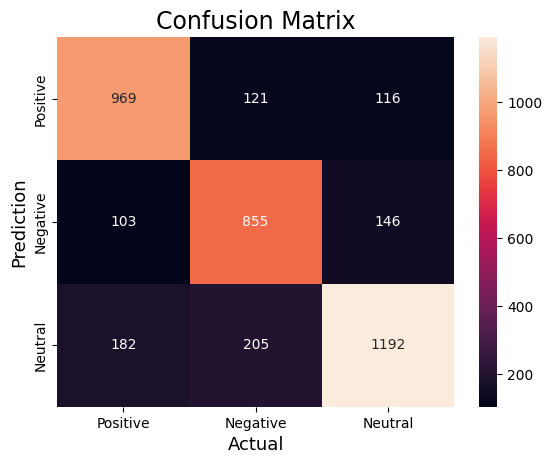

In [ ]:
import seaborn as sns
sns.heatmap(cm,
annot=True,
fmt='g',
xticklabels=['Positive','Negative','Neutral'],
yticklabels=['Positive','Negative','Neutral'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
12
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming",
            "I have never seen a terrible movie like this",
            "the movie plot is terrible but it had good acting"]
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)
# pad the sequence
padded = pad_sequences(sequences, padding='post', maxlen=200)
# Get labels based on probability 1 if p>= 0.5 else 0
prediction = model.predict(padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment : ",s)

1/1 [==============================] - 0s 212ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()